####  Image Transformations

- We’ll be restricting ourselves to 2 dimensions and talk about linear transformations first. (afterwards, expand to affine transform)
- By $2 \times 2$ matrix, we can define 3 basic linear transformations:
    - scaling: scales the x and y direction by a scalar.
    - shearing: offsets the x by a number proportional to y and x by a number proportional to x.
    - rotating: rotates the points around the origin by an angle $\theta$

- The only downside to this $2 \times 2$ matrix representation is that we cannot represent translation since it isn’t a linear transformation. How can we encapsulate translation in our matrix representation? Introducing **homogeneous coordinates**.
- $2 \times 2$ matrix transformation is equivalent to the following representation.
\begin{equation}
\begin{bmatrix}
  x' \\
  y' \\
  1 
\end{bmatrix}=
\begin{bmatrix}
  a & b & 0 \\
  c & d & 0 \\
  0 & 0 & 1
\end{bmatrix}
\begin{bmatrix}
  x \\
  y \\
  1 
\end{bmatrix}
\end{equation}

- To represent a translation, all we have to do is place 2 new parameters e and f in our third column.
- We can thus carry out translations as linear transformations in homogeneous coordinates. Note that if we require a 2D output, then all we need to do is represent M as a $2 \times 3$ matrix.
\begin{equation}
M=
  \begin{bmatrix}
    a & b & e \\
    c & d & f \\
    0 & 0 & 1
  \end{bmatrix}
\end{equation}
\begin{equation}
M=
  \begin{bmatrix}
    a & b & c \\
    d & e & f 
  \end{bmatrix}
\end{equation}

####  Bilinear Interpolation

- In the illustration below, you can clearly see that the rotation places some points at locations that are not centered in the squares.
- So for example, suppose that after rotating an image, we need to find the pixel value at the location (6.7, 3.2). 
<img src=attachment:image.png width=450>
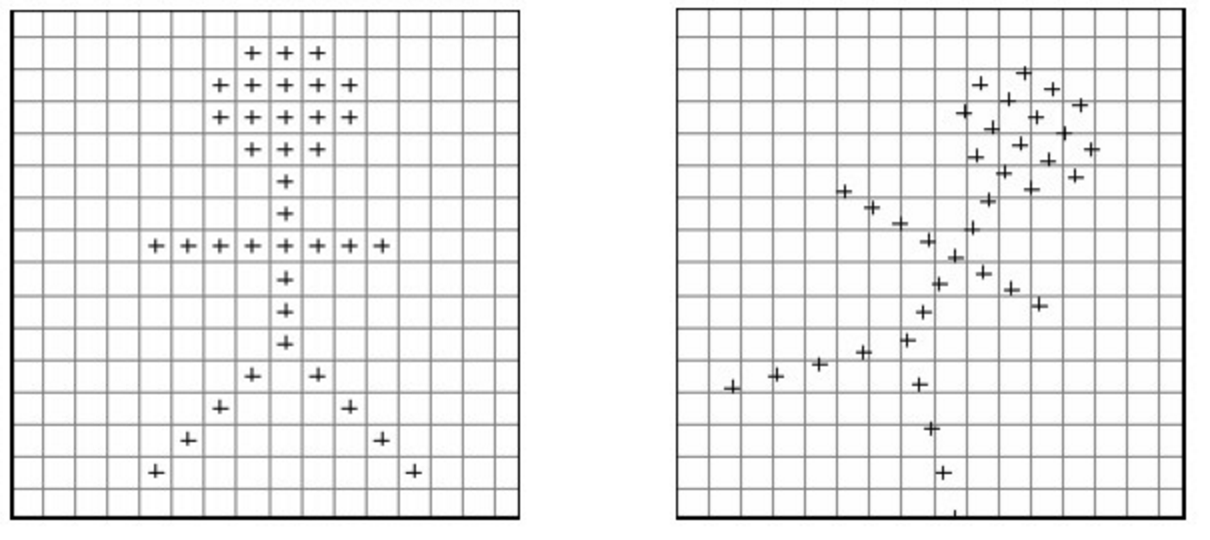

<img src=attachment:image.png width=300>
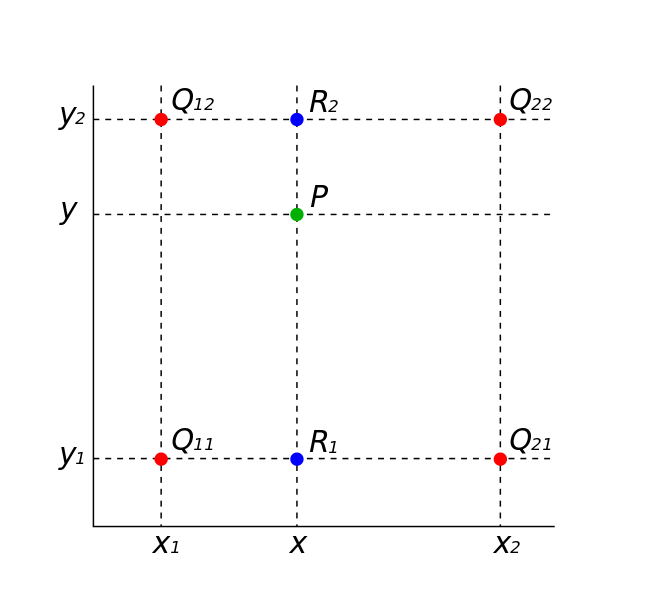

- Our goal is to find the pixel value of the point P. To do so, we calculate the pixel value of R1 and R2 using a weighted average of $(Q_{11},Q_{21})$ and $(Q_{12},Q_{22})$ respectively. 
\begin{align*}
R_1 = \frac{x_2 - x}{x_2 - x_1}Q_{11} + \frac{x - x_1}{x_2 - x_1}Q_{21} \\
R_2 = \frac{x_2 - x}{x_2 - x_1}Q_{12} + \frac{x - x_1}{x_2 - x_1}Q_{22}
\end{align*}
and finally, 
$$\boxed{P = \frac{y_2 - y}{y_2 - y_1}R_1 + \frac{y - y_1}{y_2 - y_1}R_2}$$

- An image processing affine transformation usually follows the 3-step pipeline below:

    - First, we create a sampling grid composed of (x,y) coordinates. For example, given a 400x400 grayscale image, we create a meshgrid of same dimension, that is, evenly spaced $x \in [0, W]$ and $y \in [0, H]$.
    - We then apply the transformation matrix to the sampling grid generated in the step above.
    - Finally, we sample the resulting grid from the original image using the desired interpolation technique.
- As you can see, this is different than directly applying a transform to the original image.
    - *This is because the ouput pixels are defined to lie on a regular grid, then we sample from the input images*.

In [8]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
im = Image.open("./cat.jpg")

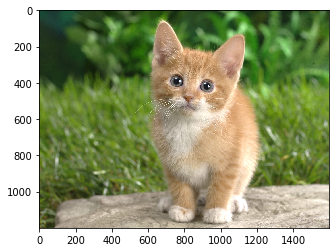

In [9]:
im_array = np.asarray(im)
plt.imshow(im_array)

In [10]:
im_array.shape

(1200, 1600, 3)

In [13]:
H, W, C = im_array.shape

In [11]:
M = np.array([[1., 0., 0.], [0., 1., 0.]])

- Now we need to write a function that will generate a meshgrid and output **a sampling grid resulting from the product of the meshgrid and the transformation matrix M**.
- Let’s go ahead and generate our meshgrid. We’ll create a normalized one, that is the values of x and y range from -1 to 1 

In [14]:
# create normalized 2D grid
x = np.linspace(-1, 1, W)
y = np.linspace(-1, 1, H)
x_t, y_t = np.meshgrid(x, y)

In [18]:
print(x_t.shape)
print(y_t.shape)

(1200, 1600)
(1200, 1600)


- Then we need to augment the dimensions to create homogeneous coordinates.

In [23]:
# reshape to (xt, yt, 1) 
ones = np.ones(1200*1600)
mesh_grid = np.vstack([x_t.flatten(), y_t.flatten(), ones])

In [30]:
# transform the sampling grid 
sampling_grid = np.matmul(M, mesh_grid)

In [31]:
sampling_grid.shape

(2, 1920000)

In [32]:
sampling_grid = sampling_grid.reshape(2, H, W)
sampling_grid.shape

(2, 1200, 1600)

In [28]:
sampling_grid = np.moveaxis(sampling_grid, 1, -1)

In [29]:
sampling_grid.shape

(2, 1600, 1200)

In [33]:
x_s = sampling_grid[0:1, :, :].squeeze()
y_s = sampling_grid[1:2, :, :].squeeze()

# rescale x and y to [0, W/H]
x = ((x_s + 1.) * W) * 0.5
y = ((y_s + 1.) * H) * 0.5

In [34]:
# grab 4 nearest corner points for each (x_i, y_i)
x0 = np.floor(x).astype(np.int64)
x1 = x0 + 1
y0 = np.floor(y).astype(np.int64)
y1 = y0 + 1

- Then, perform bilinear interpoaltion. This is how it's done.

- Recall that we can’t just blindly rush to the input image and apply our affine transformation. It’s important to first create a sampling grid, transform it, and then sample the input image using the grid.